# Predicting the Stock Market with Linear Regression

In this notebook I'll be using historical data on the price of the S&P500 Index to make a predictive model and predictions about future prices. The S&P500 is a stock market index that aggregates the stock prices of 500 large companies, more information on the S&P500 can be found [here](https://en.wikipedia.org/wiki/S%26P_500_Index). Predicting whether the index will go up or down will help forecast how the stock market as a whole will perform. 

Note: You shouldn't make trades with any models developed in this notebook. Trading stocks has risks, and nothing in this notebook constitutes stock trading advice. 

First I'll import the necessary libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style


from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## The Dataset

I'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in `sphist.csv`.

The columns of the dataset are:

- `Date` -- The date of the record.
- `Open` -- The opening price of the day (when trading starts).
- `High` -- The highest trade price during the day.
- `Low` -- The lowest trade price during the day.
- `Close` -- The closing price for the day (when trading is finished).
- `Volume` -- The number of shares traded.
- `Adj Close` -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.


I'll be using this dataset to develop the predictive model. 

In [2]:
#Read in data
data = pd.read_csv('sphist.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [3]:
#Get Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [4]:
# Fromat Date Column as datetime
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
#Sanity Check date column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       16590 non-null  datetime64[ns]
 1   Open       16590 non-null  float64       
 2   High       16590 non-null  float64       
 3   Low        16590 non-null  float64       
 4   Close      16590 non-null  float64       
 5   Volume     16590 non-null  float64       
 6   Adj Close  16590 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.4 KB


In [6]:
#Sort in oldest to newest
data.sort_values('Date', inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


Text(0, 0.5, 'Price')

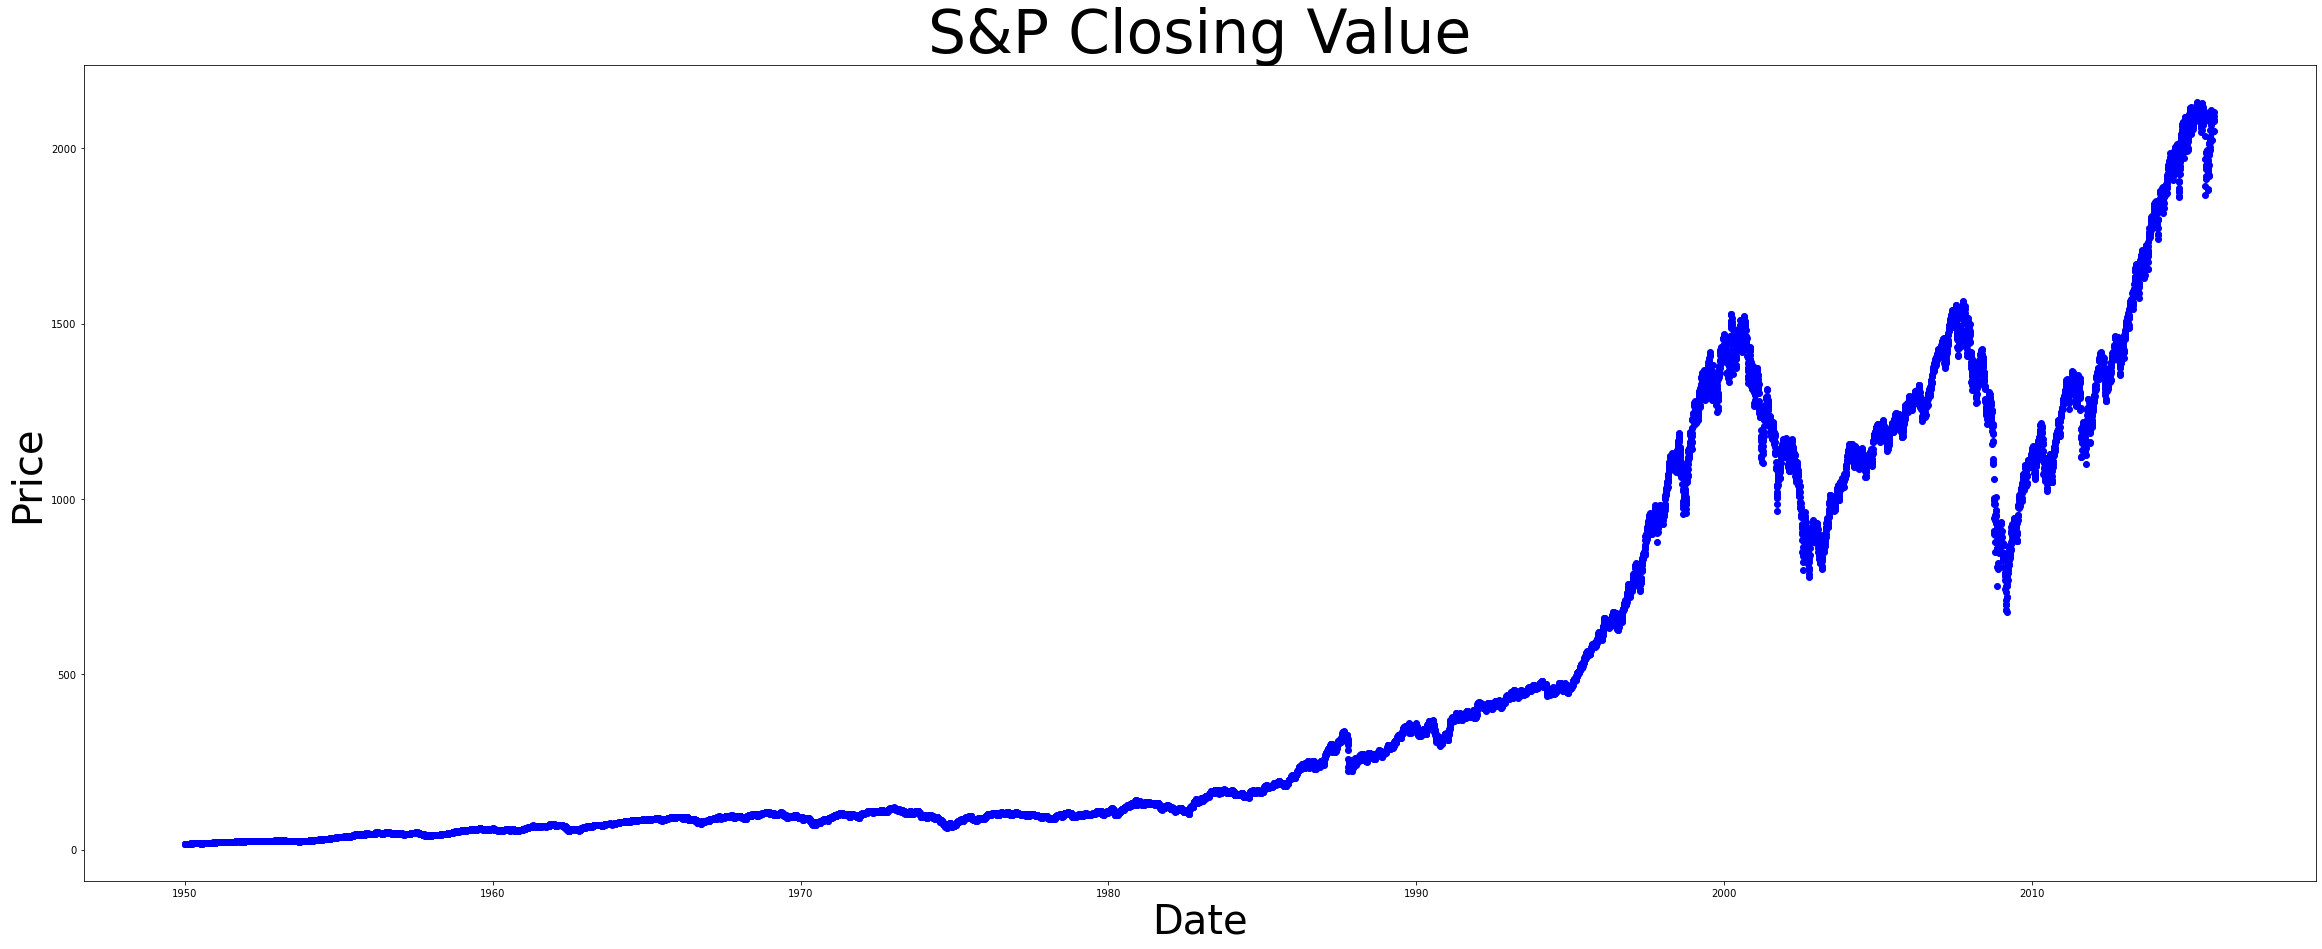

In [7]:
#Plot Closing Value
plt.figure(figsize=(40,15))
plt.scatter(data['Date'], data['Close'], c='b')
plt.title('S&P Closing Value', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Price', fontsize=40)

## Generate Features

In a normal machine learning exercise, each row is treated independently. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and can't be treated as such.

This means I'll have to be extra careful to not inject "future" knowledge into past rows when I do training and prediction. Injecting future knowledge will make our model look good when you're training and testing it, but will make it fail in the real world.

The time series nature of the data means that can I generate indicators to make our model more accurate. This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.

I will create the following features:
- `5_day_avg` - The average price from the past 5 days.
- `30_day_avg` - The average price for the past 30 days.
- `year_avg` - The average price for the past 365 days.
- `avg_ratio`- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- `5_day_std` - The standard deviation of the price over the past 5 days.
- `year_std`- The standard deviation of the price over the past 365 days.
- `std_ratio`- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

In [8]:
# The rolling mean and standard deviation will use the current day's price. 
# I use .he shift method to reindex the resulting series to shift all the values "forward" one day. 
# For example, the rolling mean calculated for 1950-01-03 will need to be assigned to 1950-01-04, and so on. 
data['5_day_avg'] = data['Close'].rolling(window=5).mean().shift(1)
data['30_day_avg']= data['Close'].rolling(window=5).mean().shift(1)
data['year_avg'] = data['Close'].rolling(window=365).mean().shift(1)
data['avg_ratio'] = data['5_day_avg']/data['year_avg']

data['5_day_std'] = data['Close'].rolling(window=5).std().shift(1)
data['year_std'] = data['Close'].rolling(window=365).mean().shift(1)
data['std_ratio'] = data['5_day_std']/data['year_std']

In [9]:
data.head(20)

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,16.900,NaN,NaN,0.157956,NaN,NaN
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,16.974,NaN,NaN,0.089051,NaN,NaN
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,17.022,NaN,NaN,0.067602,NaN,NaN
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,16.988,NaN,NaN,0.134796,NaN,NaN
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,16.926,NaN,NaN,0.196545,NaN,NaN


## Split Data

Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, the first 365 rows  don't have enough historical data to compute all the indicators. I'll remove these rows before I split the data into a training and testing set. 

I'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

In [10]:
data = data.dropna(axis=0)
data.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Adj Close     0
5_day_avg     0
30_day_avg    0
year_avg      0
avg_ratio     0
5_day_std     0
year_std      0
std_ratio     0
dtype: int64

In [11]:
train = data[data['Date']< datetime(year=2013, month=1, day=1)] 
train

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1.100000e+06,22.020000,21.800000,21.800000,19.447726,1.120954,0.256223,19.447726,0.013175
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1.120000e+06,21.910000,21.900000,21.900000,19.462411,1.125246,0.213659,19.462411,0.010978
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1.100000e+06,21.780001,21.972000,21.972000,19.476274,1.128142,0.092574,19.476274,0.004753
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1.340000e+06,21.549999,21.960000,21.960000,19.489562,1.126757,0.115108,19.489562,0.005906
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2.440000e+06,21.290001,21.862000,21.862000,19.502082,1.121008,0.204132,19.502082,0.010467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1437.360010,1326.114028,1.083889,7.622009,1326.114028,0.005748
742,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1436.620019,1326.412494,1.083087,8.589693,1326.412494,0.006476
741,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1431.228003,1326.716494,1.078775,9.058684,1326.716494,0.006828
740,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1427.685986,1326.995836,1.075878,10.208568,1326.995836,0.007693


In [12]:
test = data[data["Date"] > datetime(year=2013, month=1, day=1)]
test

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1418.641992,1327.534055,1.068629,9.820801,1327.534055,0.007398
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1425.793994,1327.908247,1.073714,22.261321,1327.908247,0.016764
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1433.702002,1328.224877,1.079412,26.274326,1328.224877,0.019782
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1443.376001,1328.557617,1.086423,27.945242,1328.557617,0.021034
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1455.267993,1328.898603,1.095093,16.453319,1328.898603,0.012381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2087.024023,2035.531178,1.025297,3.916109,2035.531178,0.001924
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2090.231982,2035.914082,1.026680,7.956808,2035.914082,0.003908
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2088.306006,2036.234356,1.025573,9.333599,2036.234356,0.004584
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2080.456006,2036.507343,1.021580,19.599946,2036.507343,0.009624


## Making Predictions

Now I will build a model and make predictions. I will use the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), also called MAE, as an error metric, because it will show how "close" the predictions are to the price in intuitive terms.


In [13]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       '5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std',
       'year_std', 'std_ratio'],
      dtype='object')

In [14]:
features = ['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std',
       'year_std', 'std_ratio']
y_train = train['Close']
y_test = test['Close']

model = LinearRegression()
model.fit(train[features], y_train) 
predictions = model.predict(test[features]) 
mae = mean_absolute_error(test['Close'], predictions)
mae

16.09914408011438

Text(0, 0.5, 'Stock Price')

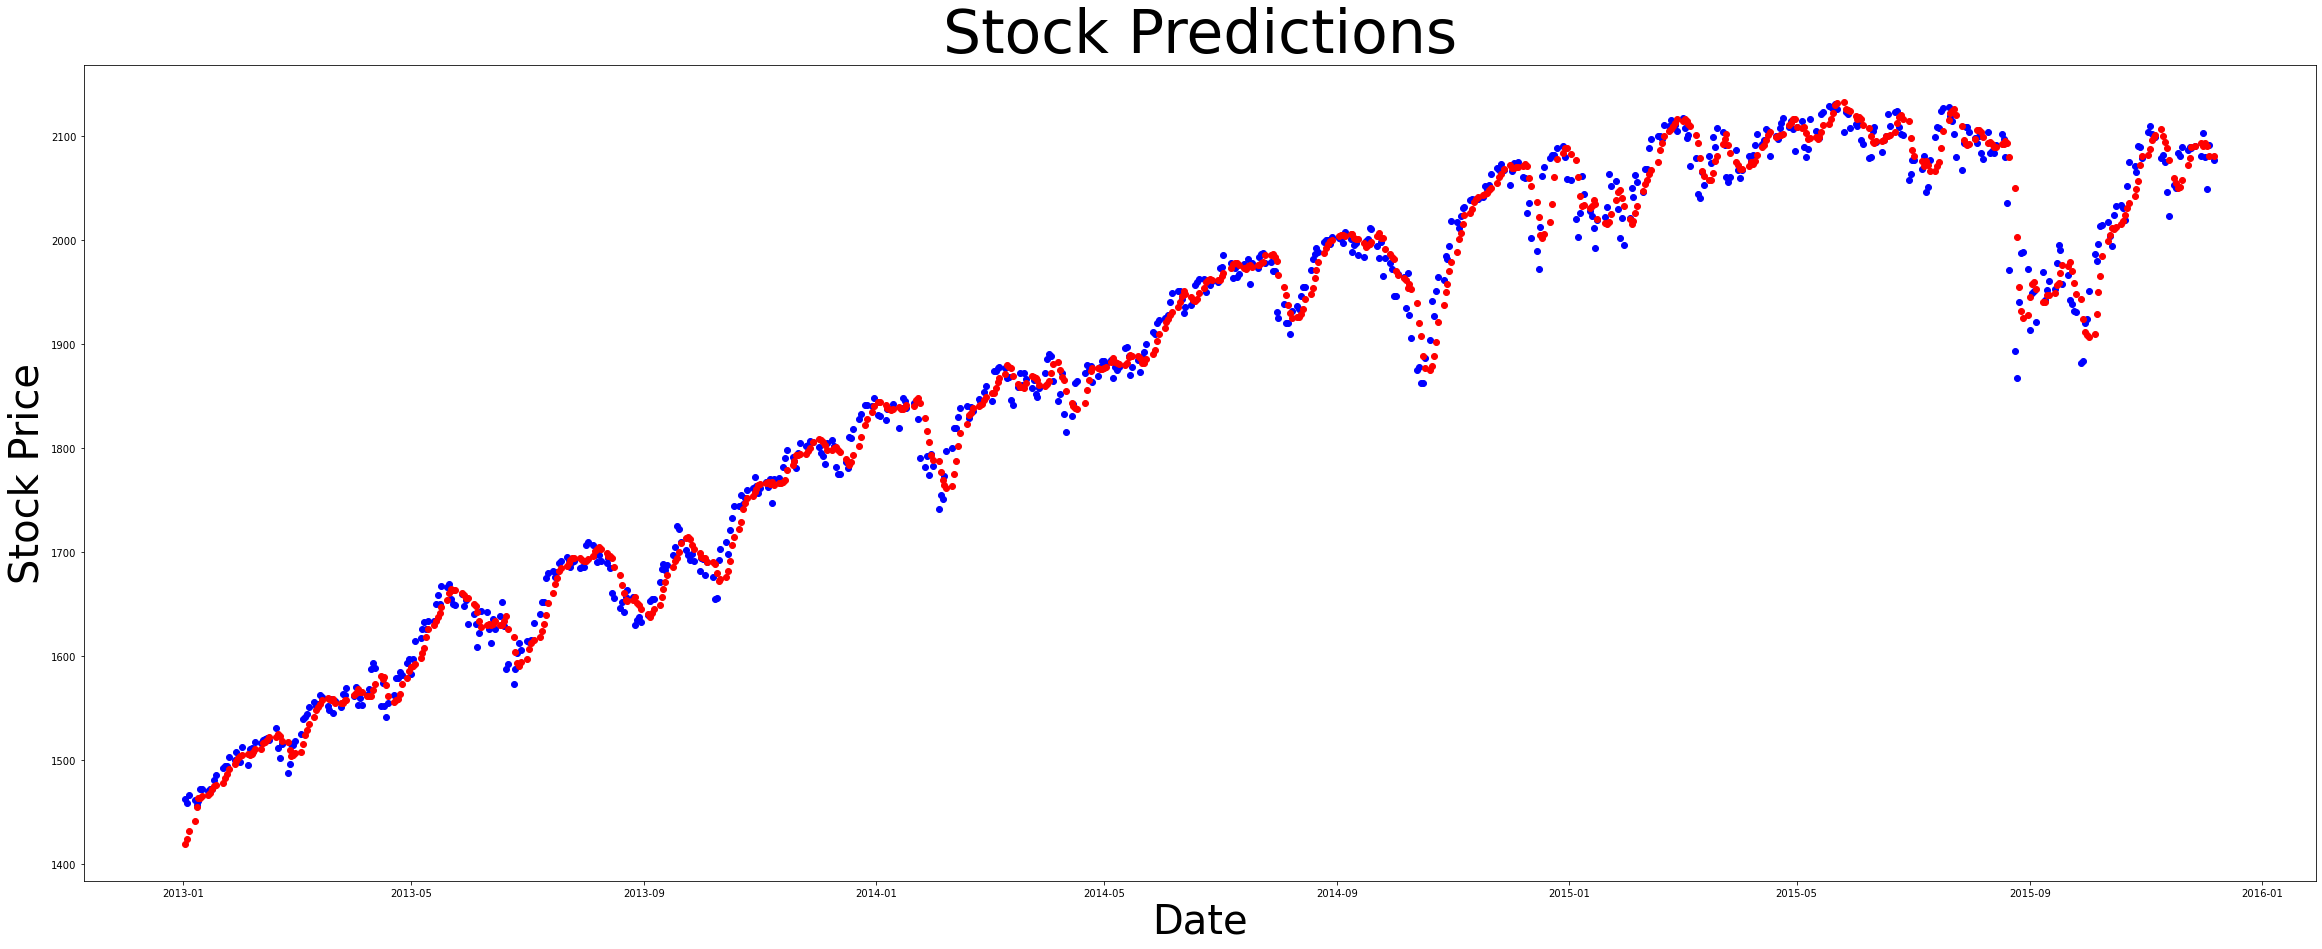

In [15]:
plt.figure(figsize=(40,15))
plt.scatter(test['Date'], test['Close'], c='b')
plt.scatter(test['Date'], predictions, c='r')
plt.title('Stock Predictions', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Stock Price', fontsize=40)

The model is off by 16 points, not too bad for a first pass. But, there is definitely room for improvement both indicator and structural wise. Below are some ideas

### Improvement Ideas

- Accuracy would improve greatly by making predictions only one day ahead. For example, train a model using data from 1951-01-03 to 2013-01-02, make predictions for 2013-01-03, and then train another model using data from 1951-01-03 to 2013-01-03, make predictions for 2013-01-04, and so on. This more closely simulates what to do if you want to trade using the algorithm.

- Try other techniques, like a random forest, and see if they perform better.

- Incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks.

- Make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.

- Make the system "higher-resolution". Make hourly, minute-by-minute, or second by second predictions. This will require obtaining more data, though.